In [174]:
# lightgbm для регрессии
from numpy import mean
from numpy import std
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from src.drawing import show_forecast_test_plot, show_time_series_only, show_acf_pacf

In [175]:
# определяем датасет
ts = pd.read_csv('train.csv')
ts['Date'] = pd.to_datetime(ts['Date'])
##print(train_values)

In [176]:
def create_date_features(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.Date.dt.dayofweek + 1
    df['year'] = df.Date.dt.year
    df["is_wknd"] = df.Date.dt.weekday // 4
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df

ts = create_date_features(ts)

In [177]:
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['lag_' + str(lag)] = dataframe['target_value'].transform(
            lambda x: x.shift(lag))
    return dataframe

ts = lag_features(ts, [1, 2, 3, 4, 5, 7, 10])


In [178]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['mean_' + str(window)] = dataframe['target_value'].transform(lambda x:
                                                                               x.shift(1).rolling(window=window, min_periods=1, win_type="triang").mean())
    return dataframe
ts = roll_mean_features(ts, [1, 2, 7, 14, 30])
ts.head()

,Date,target_value,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,...,lag_3,lag_4,lag_5,lag_7,lag_10,mean_1,mean_2,mean_7,mean_14,mean_30
0,2021-12-20,3928.770142,12,20,354,1,2021,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-21,3979.361939,12,21,355,2,2021,0,0,0,...,NaN,NaN,NaN,NaN,NaN,3928.770142,3928.770142,3928.770142,3928.770142,3928.770142
2,2021-12-22,4000.397705,12,22,356,3,2021,0,0,0,...,NaN,NaN,NaN,NaN,NaN,3979.361939,3954.066040,3945.634074,3941.418091,3941.418091
3,2021-12-23,4044.988647,12,23,357,4,2021,0,0,0,...,3928.770142,NaN,NaN,NaN,NaN,4000.397705,3989.879822,3957.572001,3953.592692,3953.592692
4,2021-12-24,4079.664062,12,24,358,5,2021,1,0,0,...,3979.361939,3928.770142,NaN,NaN,NaN,4044.988647,4022.693176,3969.895044,3965.273903,3965.273903


In [179]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['target_value']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1, 2, 3, 4, 5, 7, 10]
ts = ewm_features(ts, alphas, lags)
ts.tail()

,Date,target_value,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,...,ewm_alpha_07_lag_5,ewm_alpha_07_lag_7,ewm_alpha_07_lag_10,ewm_alpha_05_lag_1,ewm_alpha_05_lag_2,ewm_alpha_05_lag_3,ewm_alpha_05_lag_4,ewm_alpha_05_lag_5,ewm_alpha_05_lag_7,ewm_alpha_05_lag_10
361,2022-12-16,1217.359985,12,16,350,5,2022,1,0,0,...,1265.438629,1267.873721,1266.542373,1293.236414,1298.700488,1282.392310,1267.178785,1265.261317,1265.379069,1266.745013
362,2022-12-17,1178.108154,12,17,351,6,2022,1,0,0,...,1267.998966,1266.127991,1256.359422,1255.298199,1293.236414,1298.700488,1282.392310,1267.178785,1265.379445,1259.370157
363,2022-12-18,1186.421875,12,18,352,7,2022,1,0,0,...,1288.723774,1265.438629,1256.656667,1216.703177,1255.298199,1293.236414,1298.700488,1282.392310,1265.261317,1258.077107
364,2022-12-19,1176.184082,12,19,353,1,2022,0,0,0,...,1307.123199,1267.998966,1267.873721,1201.562526,1216.703177,1255.298199,1293.236414,1298.700488,1267.178785,1265.379069
365,2022-12-20,1190.293945,12,20,354,2,2022,0,0,0,...,1293.577597,1288.723774,1266.127991,1188.873304,1201.562526,1216.703177,1255.298199,1293.236414,1282.392310,1265.379445


In [180]:
ts = pd.get_dummies(ts, columns=[ 'day_of_week', 'month'])
ts.head()

,Date,target_value,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,lag_1,lag_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2021-12-20,3928.770142,20,354,2021,0,0,0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
1,2021-12-21,3979.361939,21,355,2021,0,0,0,3928.770142,NaN,...,False,False,False,False,False,False,False,False,False,True
2,2021-12-22,4000.397705,22,356,2021,0,0,0,3979.361939,3928.770142,...,False,False,False,False,False,False,False,False,False,True
3,2021-12-23,4044.988647,23,357,2021,0,0,0,4000.397705,3979.361939,...,False,False,False,False,False,False,False,False,False,True
4,2021-12-24,4079.664062,24,358,2021,1,0,0,4044.988647,4000.397705,...,False,False,False,False,False,False,False,False,False,True


In [181]:
ts['target_value'] = np.log1p(ts["target_value"].values)
ts['target_value'].head()

0    8.276336
1    8.289128
2    8.294399
3    8.305481
4    8.314015
Name: target_value, dtype: float64

In [182]:
time = ts.Date
target = ts.target_value
TRAIN_SIZE = len(target) - 7
train, test = train_test_split(ts, train_size=TRAIN_SIZE, shuffle=False)

show_time_series_only(time, target)
test_values = target[TRAIN_SIZE:]
train_values = target[:TRAIN_SIZE]

In [183]:
cols = [col for col in train.columns if col not in ['target_value', 'Date']]
Y_train = train['target_value']
X_train = train[cols]
Y_val = test['target_value']
X_val = test[cols]

In [184]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [185]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [195]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': -1,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [197]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.0188086	training's SMAPE: 1.88169	valid_1's l1: 0.025287	valid_1's SMAPE: 2.53031
[400]	training's l1: 0.0134717	training's SMAPE: 1.34782	valid_1's l1: 0.0263686	valid_1's SMAPE: 2.63862
Early stopping, best iteration is:
[207]	training's l1: 0.0183002	training's SMAPE: 1.83083	valid_1's l1: 0.0251568	valid_1's SMAPE: 2.5173


C:\Users\Osipov\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\Osipov\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\Osipov\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



In [188]:
y_pred_val = model.predict(X_val)


In [189]:
train_values = np.expm1(train_values)
y_pred_val = np.expm1(y_pred_val)
test_values = np.expm1(test_values)

In [190]:
show_forecast_test_plot(time, train_values,y_pred_val, test_values)

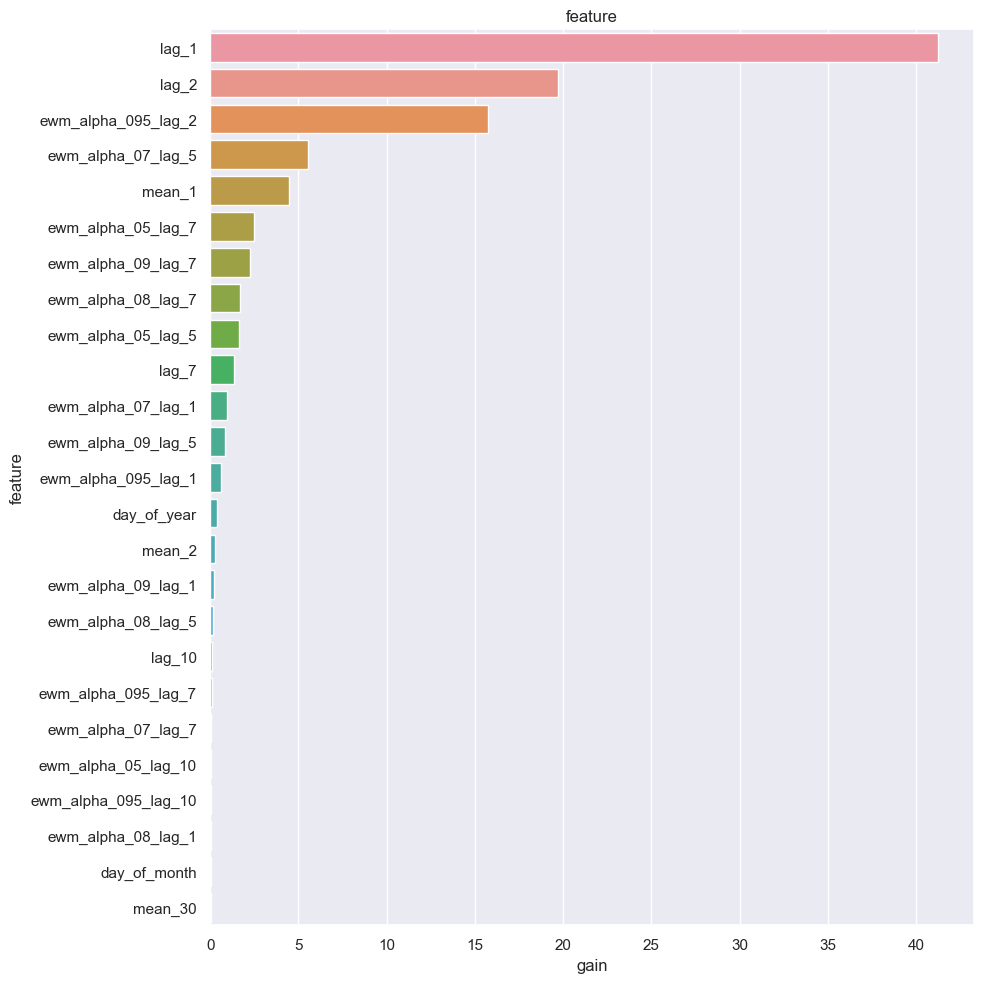

                feature  split       gain
6                 lag_1    615  41.216338
7                 lag_2     12  19.692828
19  ewm_alpha_095_lag_2     11  15.711247
43   ewm_alpha_07_lag_5     24   5.548127
13               mean_1    128   4.450530
51   ewm_alpha_05_lag_7     38   2.504464
30   ewm_alpha_09_lag_7     15   2.264171
37   ewm_alpha_08_lag_7     16   1.674881
50   ewm_alpha_05_lag_5     28   1.610662
11                lag_7     24   1.366631


In [192]:
def plot_lgb_importances(model,plot=True,num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    print(feat_imp.head(num))

plot_lgb_importances(model,30)

In [194]:
show_time_series_only(time, test_values - y_pred_val)